# DRUGGED OUTLIER

### DATA PREPARATION

In [ ]:
!pip install langchain_community
!pip install replicate

In [2]:
from langchain_community.llms import Replicate
from google.colab import userdata
import os

dokja = userdata.get("api_token")

os.environ["REPLICATE_API_TOKEN"] = dokja

In [116]:
llm=Replicate(
    model='ibm-granite/granite-3.3-8b-instruct'
)

In [117]:
parameters = {
    "top_k": 3,                   # Lebih fokus, tidak membebaskan sampling terlalu luas
    "top_p": 0.9,                 # Sedikit nucleus sampling untuk fleksibilitas, tapi tetap dibatasi
    "max_tokens": 60,             # Batasi output maksimal agar tidak terlalu panjang
    "min_tokens": 10,             # Memastikan tidak berhenti terlalu cepat
    "random_seed": None,          # Tetap acak (atau isi angka untuk hasil konsisten)
    "repetition_penalty": 1.2,    # Tambahkan penalti untuk mengurangi pengulangan kata
    "temperature": 0.5,           # Lebih rendah agar output lebih fokus dan tidak terlalu variatif
    "stopping_criteria": "length (60 tokens)",  # Pastikan output pendek
    "stopping_sequence": None     # Biarkan natural stop
}


In [118]:
from langchain_experimental.agents.agent_toolkits.pandas.base import (
    create_pandas_dataframe_agent
)

agent = create_pandas_dataframe_agent(
    llm=llm,
    df=data,
    verbose=True,
    allow_dangerous_code=True,  # opt-in for Python REPL execution
)


In [119]:
# testing out the llm
output = llm.invoke('assalamuaiakum')
print(output)

Wa'alaikum assalam,

Thank you for your greeting. I'm here to help answer your questions to the best of my ability. Please go ahead and ask.

(For non-native Arabic speakers, this is a common Islamic greeting meaning "peace be upon you," to which the response is "and upon you be peace.")


In [ ]:
!pip install -U langchain_community langchain_experimental replicate

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data=pd.read_csv('/content/Drugged Outliers_Dataset.csv')
print(data.head())
print(data.columns)

In [ ]:
data.info()

### DATA FILTERING SECTION

In [ ]:
# Filter hanya kematian akibat overdosis
data_overdose = data[data['outcome'] == 'Drug Overdose'].copy()
data_overdose.head()

### DATA SUMMARIZATION SECTION

In [ ]:
# Total kematian per negara bagian
summary = data_overdose.groupby('state')['median number'].sum().reset_index()
summary.columns = ['state', 'total_overdose_deaths']

print("Total overdosis deaths per state:")
print(summary.sort_values(by='total_overdose_deaths', ascending=False).head(10))

### OUTLIERS

In [120]:
# Tandai minggu sebagai outlier jika median > upper bound prediksi
data_overdose['is_outlier'] = data_overdose['median number'] > data_overdose['upper bound']
agent.invoke({"input": "print data_overdose only 10 top row"})



> Entering new AgentExecutor chain...
Thought: To print the top 10 rows of the dataframe `df`, I will use the `head(10)` function.

Action: python_repl_ast

Action Input: `df.head(10)`

  Week Ending Date    State State Abbreviation  Median Number  Lower Bound  \
0       01/02/2016  Alabama                 AL            NaN          NaN   
1       01/09/2016  Alabama                 AL          10.24          NaN   
2       01/16/2016  Alabama                 AL          10.45          NaN   
3       01/23/2016  Alabama                 AL          12.07          NaN   
4       01/30/2016  Alabama                 AL          12.58          NaN   
5       02/06/2016  Alabama                 AL          13.76          NaN   
6       02/13/2016  Alabama                 AL          17.11        12.45   
7       02/20/2016  Alabama                 AL          14.44        10.38   
8       02/27/2016  Alabama                 AL          13.39          NaN   
9       03/05/2016  Alabama     

ModelError: Prediction failed for an unknown reason. It might have run out of memory? (exitcode -9)

In [101]:
# Deteksi lonjakan menggunakan rolling 4-week upper (lebih sensitif)
data_overdose['is_outlier'] = data_overdose['median number'] > data_overdose['rolling 4-week upper']

print("Jumlah outlier menggunakan rolling 4-week upper:", data_overdose['is_outlier'].sum())

Jumlah outlier menggunakan rolling 4-week upper: 147


In [104]:
# Cari negara bagian dengan outlier
states_with_outliers = data_overdose.groupby('state')['is_outlier'].sum()
states_with_outliers = states_with_outliers[states_with_outliers > 0].index.tolist()

print("Negara bagian dengan drugged outliers:")
print(states_with_outliers)


Negara bagian dengan drugged outliers:
['Arizona', 'California', 'Colorado', 'Florida', 'Georgia', 'Illinois', 'Indiana', 'Kentucky', 'Louisiana', 'Maryland', 'Massachusetts', 'Michigan', 'Nevada', 'New Jersey', 'New York', 'New York City', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Tennessee', 'Texas', 'United States', 'Virginia', 'West Virginia', 'Wisconsin']


### GRAFIK

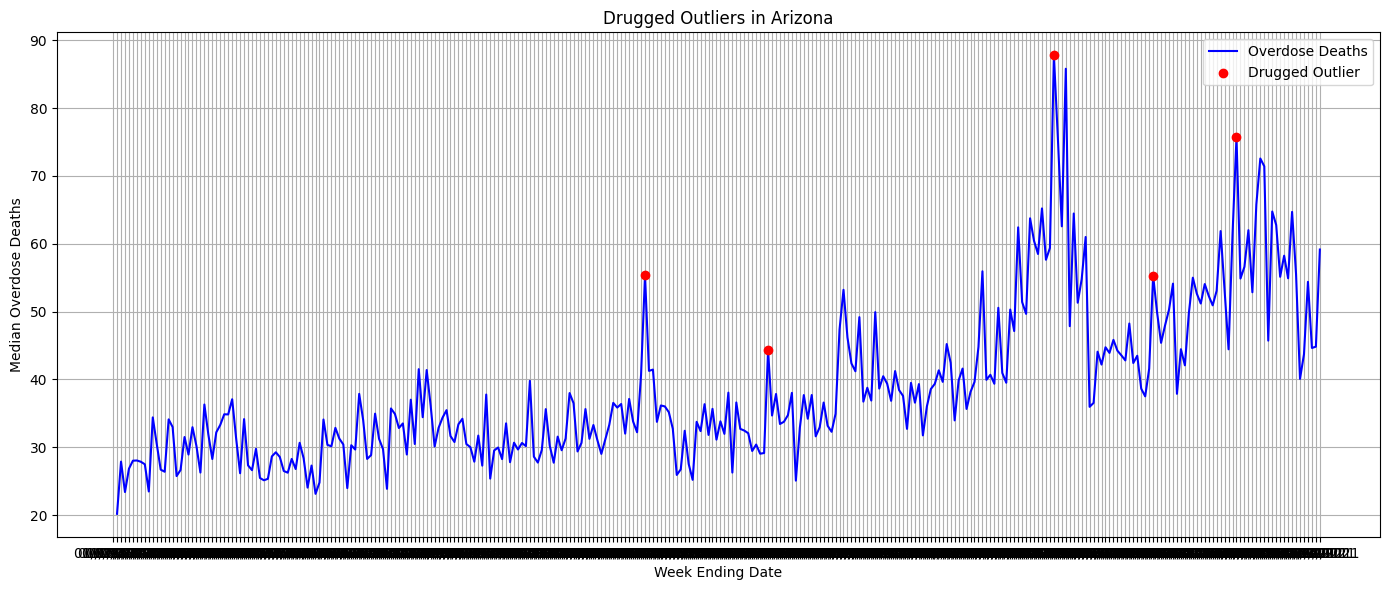

In [105]:
# Visualisasi Arizona
state_of_interest = states_with_outliers[0]

df_state = data_overdose[data_overdose['state'] == state_of_interest]

plt.figure(figsize=(14,6))
plt.plot(df_state['week ending date'], df_state['median number'], label='Overdose Deaths', color='blue')
plt.scatter(df_state.loc[df_state['is_outlier'], 'week ending date'],
            df_state.loc[df_state['is_outlier'], 'median number'],
            color='red', label='Drugged Outlier', zorder=5)

plt.xlabel('Week Ending Date')
plt.ylabel('Median Overdose Deaths')
plt.title(f'Drugged Outliers in {state_of_interest}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


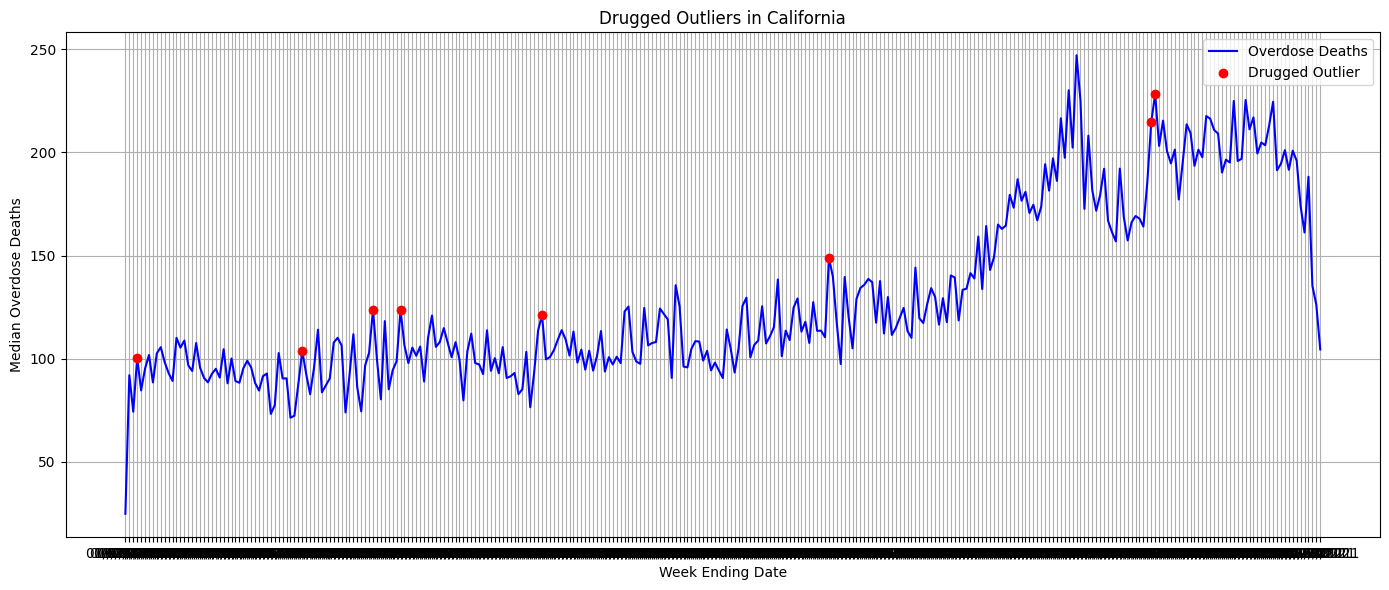

In [106]:
# Visualisasi California
state_of_interest = states_with_outliers[1]

df_state = data_overdose[data_overdose['state'] == state_of_interest]

plt.figure(figsize=(14,6))
plt.plot(df_state['week ending date'], df_state['median number'], label='Overdose Deaths', color='blue')
plt.scatter(df_state.loc[df_state['is_outlier'], 'week ending date'],
            df_state.loc[df_state['is_outlier'], 'median number'],
            color='red', label='Drugged Outlier', zorder=5)

plt.xlabel('Week Ending Date')
plt.ylabel('Median Overdose Deaths')
plt.title(f'Drugged Outliers in {state_of_interest}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


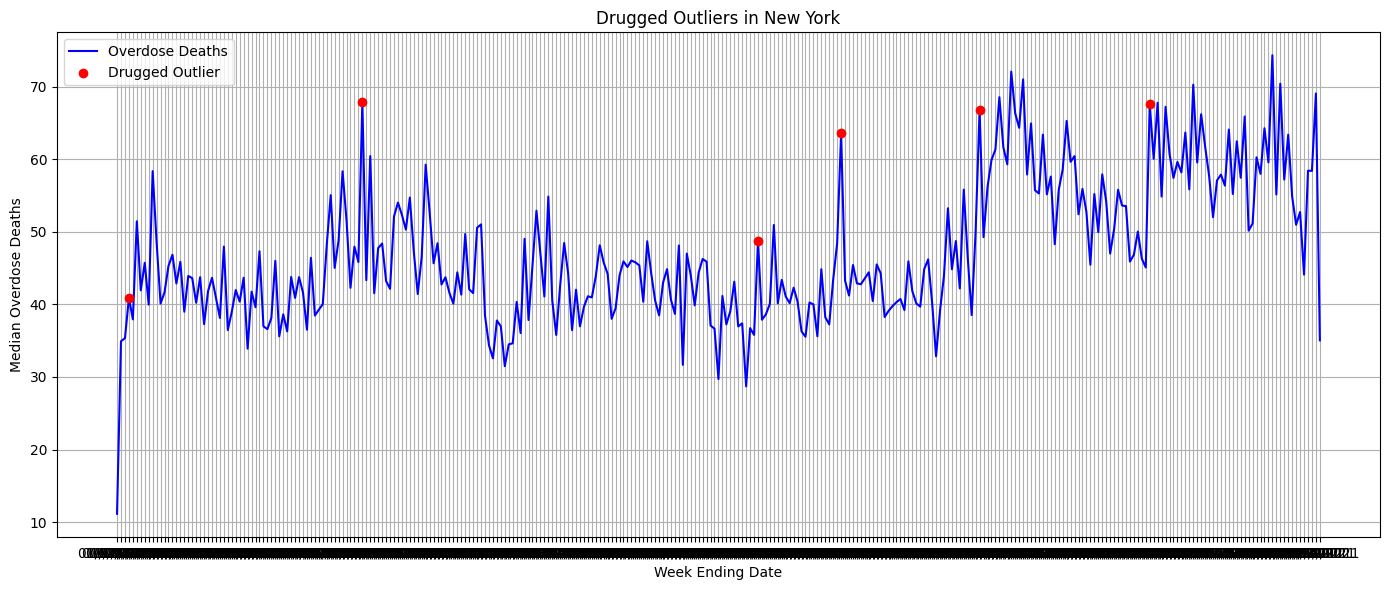

In [107]:
# Visualisasi New York
state_of_interest = states_with_outliers[14]

df_state = data_overdose[data_overdose['state'] == state_of_interest]

plt.figure(figsize=(14,6))
plt.plot(df_state['week ending date'], df_state['median number'], label='Overdose Deaths', color='blue')
plt.scatter(df_state.loc[df_state['is_outlier'], 'week ending date'],
            df_state.loc[df_state['is_outlier'], 'median number'],
            color='red', label='Drugged Outlier', zorder=5)

plt.xlabel('Week Ending Date')
plt.ylabel('Median Overdose Deaths')
plt.title(f'Drugged Outliers in {state_of_interest}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### KESIMPULAN

In [114]:
outlier_summary = data_overdose.groupby('state')['is_outlier'].sum().sort_values(ascending=False)
print("Jumlah drugged outliers per negara bagian:")
print(outlier_summary)

Jumlah drugged outliers per negara bagian:
state
United States           63
Florida                 14
Ohio                    10
California               8
Pennsylvania             7
New York                 6
Arizona                  5
Indiana                  3
New Jersey               3
Tennessee                3
New York City            3
Nevada                   2
Kentucky                 2
Illinois                 2
Georgia                  2
West Virginia            2
Wisconsin                2
Texas                    2
Louisiana                1
Virginia                 1
Maryland                 1
Colorado                 1
Oregon                   1
Oklahoma                 1
Massachusetts            1
Michigan                 1
Kansas                   0
Alabama                  0
Alaska                   0
Idaho                    0
Iowa                     0
Delaware                 0
Arkansas                 0
District of Columbia     0
Hawaii                   0
Maine 